In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Create a dataset

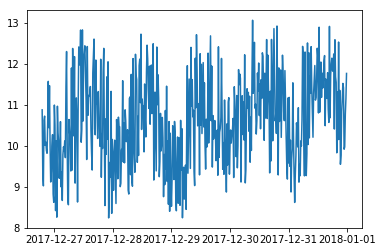

In [2]:
#Time
date = pd.date_range(start = "1/1/2014", end = "1/1/2018", freq = '15Min')[:-1]

#Ruido
season_noise = np.random.rand(len(date))
hour_noise = np.random.rand(len(date))
trend_noise = np.random.rand(len(date))


#Components of the time serie
trend = date.dayofyear/366+(date.year-2014) #Crecimiento lineal a diario
season = np.cos(4*np.pi*(date.dayofyear/365+season_noise))  #Estacionalidad ondulatoria con dos periodos al año
day = np.floor(date.dayofweek/5)            #Con esto los días Viernes y Sábado tienen valor 1 y los demás 0
hour = np.cos(2*np.pi*((date.hour-19)/24)+3*hour_noise)
anomalies = []


#TimeSerie
data = trend+season+day/2+hour+trend_noise+6
ts = pd.Series(data = data, index = date)


#Plot
plt.plot(ts[len(ts)-500:len(ts)])
plt.show()

In [3]:
#df.index == '2014-01-01 00:00:00'
#df.loc['2014-01-01 00:30:00':]
#df['week']
df = pd.DataFrame(index = ts[ts.index>="2015-01-01 00:00:00"].index, 
                  data = {'data' : ts[ts.index>="2015-01-01 00:00:00"].values,
                         'year' : ts[ts.index<"2017-01-01 00:00:00"].values,
                         'week' : ts[np.logical_and(ts.index>="2014-12-25 00:00:00",ts.index<="2017-12-24 23:45:00")].values,
                         'month' : ts[np.logical_and(ts.index>="2014-12-01 00:00:00",ts.index<="2017-11-30 23:45:00")].values})

df.head()

,data,month,week,year
2015-01-01 00:00:00,6.078541,7.533176,7.987728,6.715920
2015-01-01 00:15:00,7.229613,7.106628,6.504026,6.015525
2015-01-01 00:30:00,7.007160,8.324069,8.278862,6.280746
2015-01-01 00:45:00,7.675762,7.508968,5.861679,5.225826
2015-01-01 01:00:00,5.247966,7.567913,5.996202,4.513203


In [4]:
#Solo reescalamos si la función de activación no es relu

scaler = MinMaxScaler(feature_range=(-1,1))
df = scaler.fit_transform(df)

In [6]:
truncated_backprop_length = 200

train = np.transpose(df[:(len(df)-600),:])
test = np.transpose(df[(len(df)-600-truncated_backprop_length):,:])

# Creación de la red neuronal

In [7]:
# Hyperparams

'''
num_epochs = number of iteracions over the entire dataset
total_series_length = number of entries
truncated_backprop_length = 15
state_size = dimension of the matrix for saving the recurrence values
batch_size = numero de variables que le pasamos a la red 
num_batches = number of group of elements between trainings
'''

num_epochs = 20
total_series_length = (train.shape[1]-1)
truncated_backprop_length = 200
state_size = train.shape[0]
batch_size = 4
num_batches = total_series_length//truncated_backprop_length#//batch_size
skip = total_series_length-num_batches*truncated_backprop_length #saltamos estos elementos del dataset para tener un número entero de batches

In [8]:
# Input data

batchX_placeholder = tf.placeholder(tf.float32, [batch_size, truncated_backprop_length])
batchY_placeholder = tf.placeholder(tf.float32, [batch_size, truncated_backprop_length])
init_state = tf.placeholder(tf.float32, [batch_size, state_size]) #Aquí se pasa la información de los datos anteriores (recurrencia)

In [9]:
# Recurrent Neural Net

'''
Red neuronal con una capa oculta recurrente (W,b) y una capa de salida (W2,b2). Data un set de datos de batch_size
entradas, al introducirlo en la red, se ejecutan batch_size iteraciones sobre la primera capa

Capa recurrente:
    - Recibe un vector de datos de entrada concatenado con un array(state_size,state_size), por eso W tiene state_size+1
      columnas.
    - Para un batch de datos de batch_size entradas, se ejecutan batch_size iteraciones sobre la primera capa y se obtiene
      de salida una lista de batch_size vectores antes de pasar los resultados a la siguiente capa


Capa de salida:
    - Recibe, para cada iteración un array(state_size,1) y devuelve un número
    - Se itera sobre los batch_size elementos de la lista que se obtiene de la capa anterior
'''

# Hidden layer
W = tf.Variable(np.random.rand(state_size+1, state_size), dtype=tf.float32)
b = tf.Variable(np.zeros((1,state_size)), dtype=tf.float32)

# Output layer
W2 = tf.Variable(np.random.rand(state_size, 1),dtype=tf.float32)
b2 = tf.Variable(np.zeros((1,1)), dtype=tf.float32)

In [10]:
# Unpack the input data

'''
Esto se hace para conviertir un array con dimensiones (m,n) en una lista de n arrays de dimensión (m,1).
Cada elemento de la lista es un set de datos del que se saca una predicción. 

    batchX_placeholder: np.array(m,n)
    batchX_placeholder: np.array(m,n)
    inputs_series: list(np.array(m,1), self.len = n)
    labels_series: list(np.array(m,1), self.len = n)
    
Esto se hace para poder iterar de manera más sencilla sobre las columnas de las matrices de los datos de entrada.
'''

inputs_series = tf.unstack(batchX_placeholder, axis=1)
labels_series = tf.unstack(batchY_placeholder, axis=1)
labels = batchY_placeholder[1,:]

In [16]:
# Forward Propagation

current_state = init_state  #Aquí guardamos la salida de la hidden_layer en memoria, para introducirla en la siguiente iteración (RNN)
states_series = [] #Aquí guardamos todas las salidas para calcular el error

'''
Pasamos cada batch de datos a la red, hacemos la propagación directa y guardamos las salidas de la hidden layer
para introducirlas en la siguiente iteración. De esta forma obtenemos, del conjunto de iteraciones una lista de
arrays(state_size,1).

Recorremos la lista de la hiden layer aplicándole la output_layer. Esto nos da un vector de batch_size predicciones.
'''

# Hidden layer

for current_input in inputs_series:

    
    current_input = tf.reshape(current_input, [batch_size, 1]) # Esto es porque tiene que tener formato (n,1) y no (n,) para que sume bien con el vector b
    input_and_state_concatenated = tf.concat([current_input, current_state],1)  # Concatenamos a la entrada, las salidas de la salida de la iteración anterior
    next_state = tf.sigmoid(tf.matmul(input_and_state_concatenated, W) + b)  # Suma y activación de los datos de entrada y los datos de salida de la iteración anterior

    
    states_series.append(next_state) #Guardamos la salida pasársela a la capa siguiente.
    current_state = next_state #Guardamos la salida para la iteración siguiente.
    
    
    
    
# Output layer

logits_series = [tf.matmul(state, W2) + b2 for state in states_series]  #Comprehension list para iterar sobre todos lo elementos de salida de la capa anterior
predictions_series = [tf.sigmoid(logits) for logits in logits_series]

In [12]:
# Loss Calculation

'''
Calculamos la función de perdida para cada uno de las predicciones del batch y luego calculamos el valor medio
'''

#losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits, labels = labels) for logits, labels in zip(logits_series,labels_series)]
#losses = [tf.reduce_mean(tf.square(logits-labels)) for logits, labels in zip(logits_series,labels_series)]
losses = [tf.losses.mean_squared_error(tf.reshape(labels, [batch_size, 1]),logits) for logits, labels in zip(predictions_series,labels_series)]
total_loss = tf.reduce_mean(losses)

In [13]:
# Backpropagation

train_step = tf.train.AdagradOptimizer(0.003).minimize(total_loss) # gracias google :_)
#train_step = tf.train.GradientDescentOptimizer(0.03).minimize(total_loss)

# Visualización de los resultados

In [14]:
#visualizer
def plot(loss_lis):
    #plt.subplot(2, 3, 1)
    plt.cla()
    plt.plot(loss_list)
    plt.draw()
    plt.pause(0.0001)

# Ejecutamos el entrenamiento

Epoch 0 Step 522 Loss 0.196993


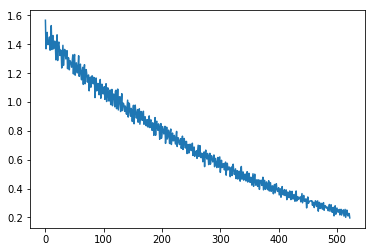

In [18]:
sess = tf.Session()

#Inicialización   

sess.run(tf.global_variables_initializer())
plt.ion() #initialize the figure
plt.figure()
plt.show() #show the graph
loss_list = [] #to show the loss decrease





#x,y = train[:,0:total_series_length],np.roll(train,-1,axis = 1)[:,:total_series_length]
x,y = train[:,0:total_series_length],train[:,1:(total_series_length+1)]
first_current_state = np.zeros((batch_size, state_size)) # Estado inicial cero


# Iteramos sobre los datos num_epoch veces
for epoch_idx in range(num_epochs):
    _current_state = first_current_state
    
    
    
# Separamos los datos en batches    
    for batch_idx in range(num_batches):
        '''
            starting and ending point per batch
            since weights reoccuer at every layer through time
            These layers will not be unrolled to the beginning of time, 
            that would be too computationally expensive, and are therefore truncated 
            at a limited number of time-steps
        '''
        
        start_idx = batch_idx * truncated_backprop_length+skip
        end_idx = start_idx + truncated_backprop_length

        batchX = x[:,start_idx:end_idx]
        batchY = y[:,start_idx:end_idx]
            
        _total_loss, _train_step, _current_state, _predictions_series = sess.run(
            [total_loss, train_step, current_state, predictions_series],
            feed_dict={
                    batchX_placeholder:batchX,
                    batchY_placeholder:batchY,
                    init_state:_current_state
                })

        loss_list.append(_total_loss)

        if batch_idx==(num_batches-1):
            print('Epoch',epoch_idx,"Step",batch_idx,"Loss", _total_loss)
            plot(loss_list)
            
#        if batch_idx==0:
#            first_current_state=_current_state


plt.ioff()
plt.show()

# Predicción

In [19]:
# New Hyperparams

'''
num_epochs = number of iteracions over the entire dataset
total_series_length = number of entries
truncated_backprop_length = 15
state_size = dimension of the matrix for saving the recurrence values
batch_size = numero de variables que le pasamos a la red 
num_batches = number of group of elements between trainings
'''

total_series_length = (test.shape[1])
truncated_backprop_length = 200
num_batches = total_series_length//truncated_backprop_length#//batch_size
#skip = total_series_length-num_batches*truncated_backprop_length #saltamos estos elementos del dataset para tener un número entero de batches

In [21]:
prediction = []
for batch_idx in range(num_batches):
    
    start_idx = batch_idx * truncated_backprop_length
    end_idx = start_idx + truncated_backprop_length
    
    x=test[:,start_idx:end_idx]
    
    
    _predictions_series = sess.run([predictions_series],
                                   feed_dict={
                                       batchX_placeholder:x,
                                       init_state:_current_state
                                   })
    
    prediction = prediction + _predictions_series[0]

In [23]:
#np.transpose(np.stack(_predictions_series[0], axis = 1))[0].shape
prediction = np.stack(prediction,axis = 0)[:,:,0]
#prediction = scaler.inverse_transform(prediction)
prediction = prediction*ts.values[-1600:-800].std()/prediction.std()
prediction = prediction+ts.values[-1600:-800].mean()-prediction.mean()

In [24]:
prediction_date = pd.date_range(end = "1/1/2018", freq = '15Min', periods = 800)
prediction_ts = pd.Series(data = prediction[:,0], index = prediction_date)

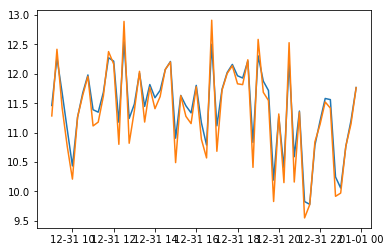

In [25]:
start = 60

predict_df = pd.DataFrame(index = ts[len(ts)-start:len(ts)].index, 
                  data = {'real' : ts[len(ts)-start:len(ts)].values,
                         'predict' : prediction_ts[len(prediction_ts)-start:len(prediction_ts)].values
                         })

plt.figure()
plt.plot(predict_df)